In [41]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')

GRT_QUERY_ENDPOINT = "https://api.thegraph.com/subgraphs/name/convex-community/volume-avalanche-test"

def grt_query(query):
    r = requests.post(GRT_QUERY_ENDPOINT, json={'query': query})
    return r.json()['data']

pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [42]:
fee_query = """
{ pools(first: 1000) {
  isV2
  id
  name
  dailyPoolSnapshots(first: 1000 orderBy: timestamp orderDirection: desc) {
    timestamp
    adminFeesUSD
    lpFeesUSD
    totalDailyFeesUSD
    eventFeesUSD
    baseApr
    tvl
  }
}
}
"""

In [43]:
data = grt_query(fee_query)['pools']
df = pd.DataFrame([{k: v for k, v in dict({key: val for key, val in entry.items() if key in ['id', 'isV2', 'name']}, **snapshot).items()} for entry in data for snapshot in entry['dailyPoolSnapshots']])
df['totalDailyFeesUSD'] = df['totalDailyFeesUSD'].astype(float)
df['eventFeesUSD'] = df['eventFeesUSD'].astype(float) * 2
df['timestamp'] = pd.to_datetime(df['timestamp'],unit='s')
df = df.sort_values('timestamp', ascending=True)
df

,isV2,id,name,timestamp,adminFeesUSD,lpFeesUSD,totalDailyFeesUSD,eventFeesUSD,baseApr,tvl
7077,False,0x7f90122bf0700f9e7e1f688fe926940e8839f353,Curve.fi avDAI/avUSDC/avUSDT,2021-10-05,0,0,0.00,0.00,0,105846509.083071062359793376
10346,True,0xb755b949c126c04e0348dd881a5cf55d424742b2,Curve USD-BTC-ETH,2021-10-05,0,0,0.00,0.00,0,3213274.849910534691357204
1307,False,0x16a7da911a4dd1d83f3ff066fe28f3c792c50d90,Curve.fi avWBTC/renBTC,2021-10-05,0,0,0.00,0.00,0,2270400.554406010004696064728838022
7076,False,0x7f90122bf0700f9e7e1f688fe926940e8839f353,Curve.fi avDAI/avUSDC/avUSDT,2021-10-06,27278.42512796733377864408859795363,27278.42512796733377864408859795363,54556.85,0.00,0.0001351613112763929549657889846406916,222251001.0032855439021031145070523
10345,True,0xb755b949c126c04e0348dd881a5cf55d424742b2,Curve USD-BTC-ETH,2021-10-06,1334.690251579718393748403034199581,1334.690251579718393748403034199581,2669.38,0.00,0.0002254762008962015425209509405297315,5919474.667713419778423072
...,...,...,...,...,...,...,...,...,...,...
3587,False,0x3d49594ed8c108f817512829c102e4059c76a220,Curve.fi Factory USD Metapool: PUCrvPool,2022-07-20,0.00006485384192602049099757965135557212,0.00006485384192602049099757965135557208,0.00,0.00,0.00001155513507072207380888034770682062,5.6125559354424587748
438,False,0x07094ab16ad163f21c76adcedc36ad8e494fab74,Curve.fi Factory USD Metapool: USDC/av3CRV,2022-07-20,0,0,0.00,0.00,0,0
10347,False,0xb89b080bb9fb489516fc7fc98bc4eb3f5a92c54e,Curve.fi Factory Plain Pool: UST (wormhole),2022-07-20,0,0,0.00,0.00,0,2994.856731797294177411690253154148
5160,False,0x5f16c819c22009746b79d3170d8c214c7c950b4e,Curve.fi Factory USD Metapool: TSD,2022-07-20,0,0,0.00,0.00,0,0


<AxesSubplot:xlabel='timestamp'>

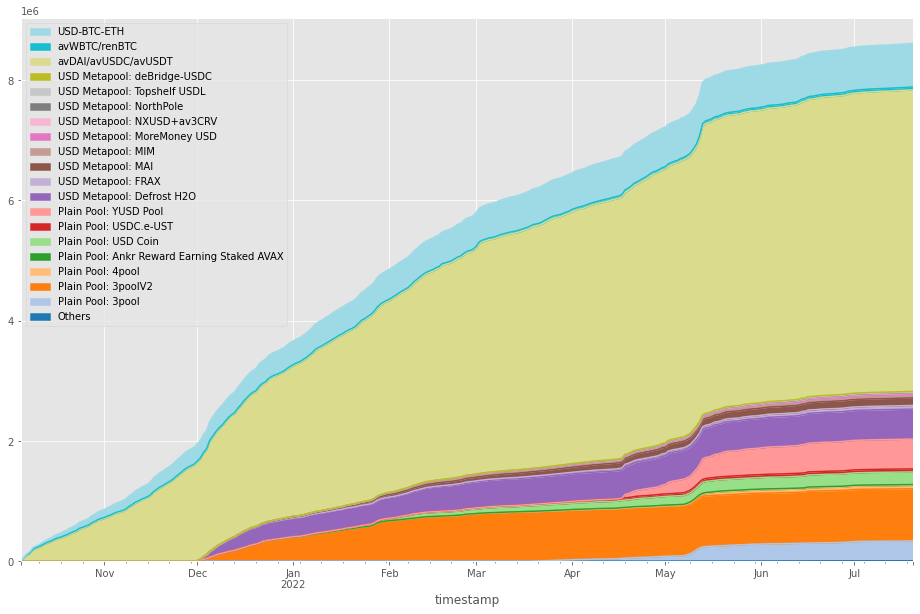

In [44]:
df['cumulativeDailyFeesUSD'] = (df['totalDailyFeesUSD']).groupby(df['id']).cumsum()
chart_data = df[['name', 'timestamp', 'cumulativeDailyFeesUSD']].pivot_table('cumulativeDailyFeesUSD', ['timestamp'], 'name')
top_performers = chart_data.mean().sort_values(ascending=False)[:19].index.tolist()
df_others = df.copy()
df_others['name'] = df_others['name'].apply(lambda x: x if x in top_performers else 'Others')
df['cumulativeDailyFeesUSD'] = (df['totalDailyFeesUSD']).groupby(df['id']).cumsum()
chart_data_others = df_others[['name', 'timestamp', 'cumulativeDailyFeesUSD']].pivot_table('cumulativeDailyFeesUSD', ['timestamp'], 'name')
chart_data_others['Others'] = df_others[df_others['name'] == 'Others'][['timestamp', 'cumulativeDailyFeesUSD']].groupby('timestamp').sum()['cumulativeDailyFeesUSD']
chart_data_others.columns = [s.replace('Curve.fi Factory ', '').replace('Curve.fi ', '').replace('Curve ', '') for s in chart_data_others.columns]
cols = chart_data_others.columns.tolist()
chart_data_others[([cols[-1], *cols[1:-1], cols[0]])].plot.area(figsize=(16, 10), legend='reverse', colormap="tab20")

In [45]:
WEEK = 3600 * 24 * 7
df_week = pd.DataFrame([{k: v for k, v in dict({key: val for key, val in entry.items() if key in ['id', 'isV2', 'name']}, **snapshot).items()} for entry in data for snapshot in entry['dailyPoolSnapshots']])
df_week['totalDailyFeesUSD'] = df_week['totalDailyFeesUSD'].astype(float)
df_week['timestamp'] = df_week['timestamp'].apply(lambda x: ((int(x) // WEEK) * WEEK))
df_week['timestamp'] = pd.to_datetime(df_week['timestamp'],unit='s')
df_week = df_week.sort_values('timestamp', ascending=True)
df_week[['totalDailyFeesUSD', 'timestamp', 'name', 'id']].groupby(['timestamp']).sum()

,totalDailyFeesUSD
timestamp,
2021-09-30,58366.97
2021-10-07,282902.65
2021-10-14,176921.55
2021-10-21,194602.55
2021-10-28,198113.65
2021-11-04,210556.76
2021-11-11,269745.33
2021-11-18,271186.03
2021-11-25,291296.87


In [47]:
df_week[['totalDailyFeesUSD', 'timestamp', 'name', 'id']].groupby(['timestamp']).sum().sum() / 2

totalDailyFeesUSD   4346649.57
dtype: float64